<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии." data-toc-modified-id="Модель-линейной-регрессии.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии.</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-Catboost" data-toc-modified-id="Модель-Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Catboost</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
!pip install optuna
import optuna
import warnings
warnings.filterwarnings("ignore")



In [2]:
# При чтении сразу передадим параметры для распознавания даты и использовании их как индекса
data=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


***Данные разбиты на 10минутные интервалы.При ресемплировании будем использовать функцию суммы.***

In [4]:
#Посмотрим описательную статистику по заказа
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


***ВЫбросов нет,нулевые значения возможны в ночные часы.***

In [5]:
#Проверим пропуски
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
#Проверим в правильном ли порядке стоят даты
data=data.sort_index(ascending=True)
data.index.is_monotonic

True

In [7]:
#Проведем ресемплирование по часу
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


***Данные приведены к условию задачи***

## Анализ

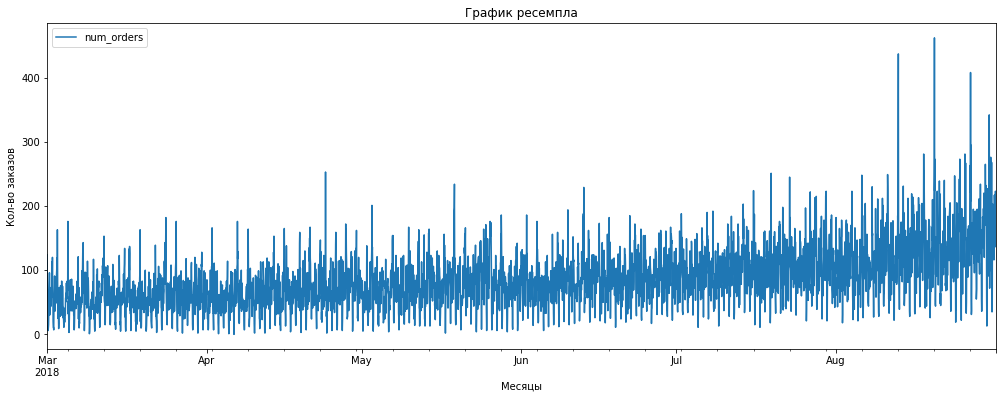

In [8]:
#Построим график ресемплированных данных
figsize = (17, 6)
data.plot(figsize=figsize)
plt.title('График ресемпла')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

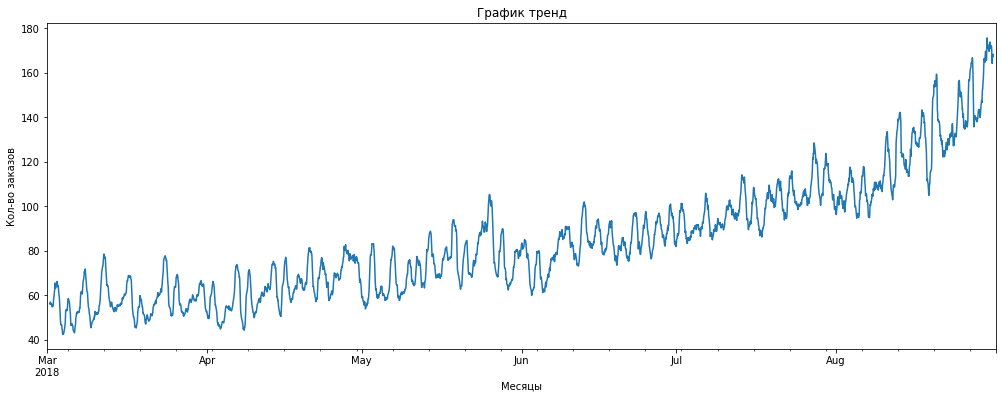

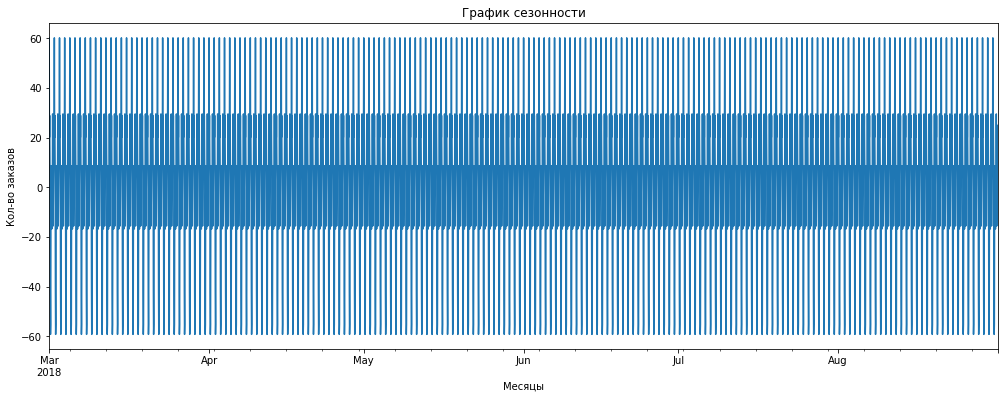

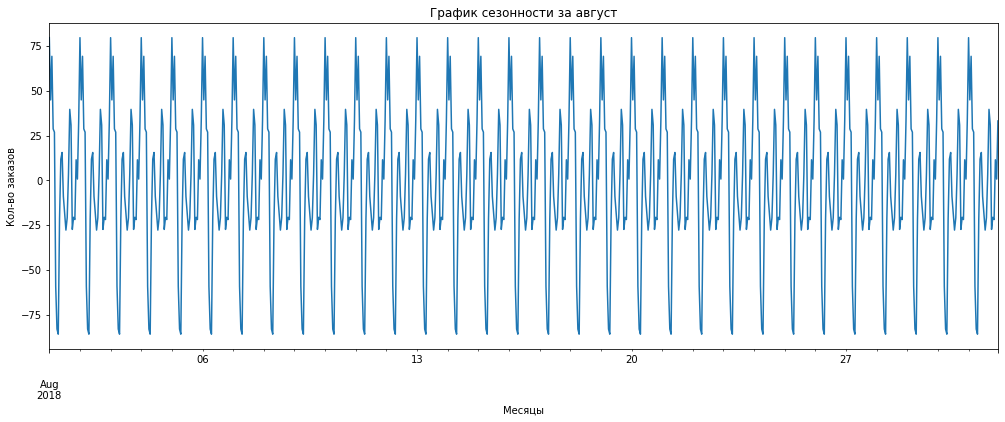

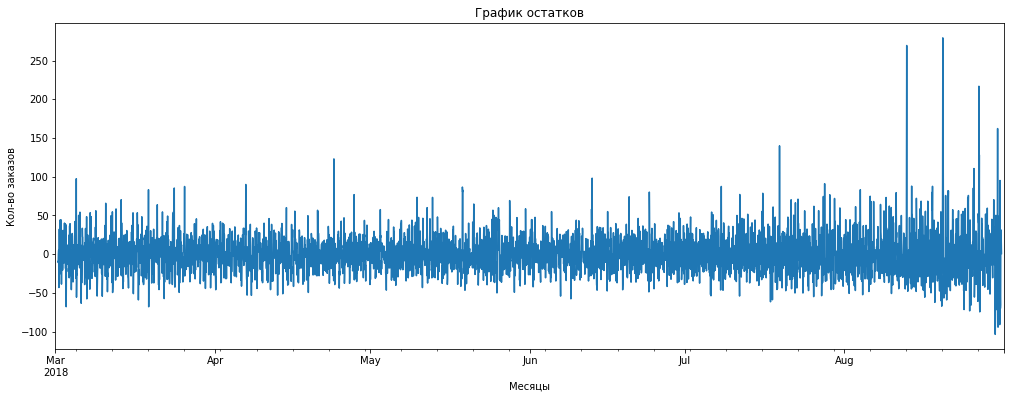

In [9]:
#Разложим на тренд, сезонность и остаток
decomposed_data = seasonal_decompose(data)
#Постороим график тренда
decomposed_data.trend.plot(figsize=figsize)
plt.title('График тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()
#Постороим график сезонности
decomposed_data.seasonal.plot(figsize=figsize)
plt.title('График сезонности')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

#Сезонная составляющая не очень информативна,срежем данные на неделю.
data_aug = data['2018-08-01':]
decomposed_data_aug = seasonal_decompose(data_aug)
decomposed_data_aug.seasonal.plot(figsize=figsize)
plt.title('График сезонности за август')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()
#Постороим график остатков
decomposed_data.resid.plot(figsize=figsize)
plt.title('График остатков')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

***После seasonal_decompose можно сделать следущие выводы:***

-Данные имеют восходящий тренд к концу лета,когда проходит время отпусков и люди возвращаются.

-Наблюдается сезонность с периодом 1 сутки

-Остатки не содержат систематические паттерны.

***Далее нам надо будет проверить ряд на стационарность***

Text(0, 0.5, 'Кол-во заказов')

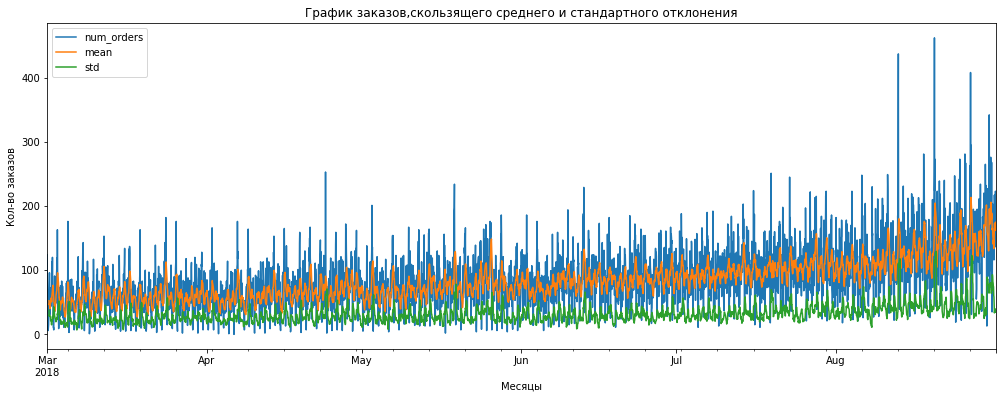

In [10]:
#Добавим к данным скользящее среднее и скользящее стандартное отклонение
data['mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()
data.plot(figsize=figsize)
plt.title('График заказов,скользящего среднего и стандартного отклонения')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')

***Стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Как мы видим среднее и стандартное отклоненеие меняется вместе с трендом,а следовательно наш ряд нельзя считать стационарным,а значит при создании признаков нам будет необходимо добавлять разности временного ряда,которые более стационарны, чем сам ряд.***

In [11]:
#Удалим,т.к в дальнейшем добавить ,чтобы потом сделать размер окна динамическим в фунции признаков.
data=data.drop(['mean','std'],axis=1)

## Обучение

***Для начала напишем функцию,которая создаст признаки,необходимые для обучения моделей***

In [12]:

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek#День недели
    data['hour'] = data.index.hour#Час
    data['day'] = data.index.day#Число
    data['month'] = data.index.month#Меесяц
    #Добавлем разности временного с ряда с плавающим лагом
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
     #Добавляем скользящее среднее с плавающим окном
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data
     

### Модель линейной регрессии.

In [13]:
#Создаем признаки 
make_features(data,100,100)
#Делим на трейн,валид и тест.Отключаем перемешивание для корректного обучения.
train, valid = train_test_split(data, shuffle=False, test_size=.2)
train = train.dropna()

valid, test = train_test_split(valid, shuffle=False, test_size=.5)

features_train = train.drop('num_orders', axis=1)
target_train = train.num_orders

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid.num_orders

features_test = test.drop('num_orders', axis=1)
target_test = test.num_orders

In [14]:
# Инициируем модель
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)   
rmse = mean_squared_error(target_valid, predictions) ** .5
print('RMSE на модели линейной регрессии',rmse)


RMSE на модели линейной регрессии 30.02225233341899


### Модель случайного леса

In [15]:
#Инициируем модель
model=RandomForestRegressor()
# Создание TimeSeriesSplit с указанием количества разбиений
tscv = TimeSeriesSplit(n_splits=5)
#Задаем параметры перебора
parametrs={'n_estimators':[1,100],
            'max_depth':[1,10],
            'random_state':[12345]}
# Ищем лучшие ГП по метрике MSE
taxi_ord = RandomizedSearchCV(model,parametrs, cv=tscv,scoring ='neg_root_mean_squared_error')
taxi_ord.fit(features_train, target_train)
predictions=taxi_ord.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions) ** .5
print('RMSE на модели случайного леса',rmse, " с параметрами",taxi_ord.best_params_)

RMSE на модели случайного леса 31.717743762655925  с параметрами {'random_state': 12345, 'n_estimators': 100, 'max_depth': 10}


### Модель Catboost

In [16]:
#Для перебора гиперпараметров воспользуемся Optuna
#определим функцию оптимизации
def objective(trial):
    params = {'iterations':100,
             'depth':trial.suggest_int('depth',2,10),
             }
    model=CatBoostRegressor(**params,verbose=False)
    model.fit(features_train,target_train)
    pred_test=model.predict(features_valid)
    rmse=mean_squared_error(target_valid,pred_test)**0.5
    return rmse

In [17]:
#Создадим объект study и запустим оптимизацию
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100,n_jobs=-1)
##Вытащим лучшие гиперпараметры 
best_params=study.best_params
print(best_params)

[I 2023-07-08 06:31:38,672] A new study created in memory with name: no-name-4f0de1e4-9d30-4909-b383-98a78a2df790
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-07-08 06:31:49,478] Trial 2 finished with value: 31.432725732356662 and parameters: {'depth': 3}. Best is trial 2 with value: 31.432725732356662.
[I 2023-07-08 06:31:50,273] Trial 5 finished with val

{'depth': 5}


In [18]:
print('Минимальное значение метрики Rmse',study.best_trial.value)

Минимальное значение метрики Rmse 30.436143175979954


### Модель LightGBM

In [19]:
def trial(trial):
    # Определение гиперпараметров для оптимизации
        params = {
        'objective': 'regression',
        'metric': 'mean_squared_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50)}
        # Создание модели LightGBM
        model = lgb.LGBMRegressor(**params)
        # Обучение модели
        model.fit(features_train,target_train, eval_set=[(features_valid,target_valid)],)
        pred_val = model.predict(features_valid)
        rmse=mean_squared_error(target_valid,pred_val)**0.5
        return rmse

In [20]:
## Обучение модели с определенными гиперпараметрами
study = optuna.create_study(direction='minimize')
study.optimize(trial, n_trials=30,n_jobs=-1)

[I 2023-07-08 06:39:09,124] A new study created in memory with name: no-name-ec21d9ba-8230-46b6-804f-ed8d0b6b79a2


[LightGBM] [Warning] bagging_fraction is set=0.30797172676723183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30797172676723183
[LightGBM] [Warning] bagging_fraction is set=0.8017354348544425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8017354348544425
[LightGBM] [Warning] bagging_fraction is set=0.52071338905882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.52071338905882
[LightGBM] [Warning] bagging_fraction is set=0.20029579182252172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20029579182252172
[LightGBM] [Warning] bagging_fraction is set=0.5569881708302974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5569881708302974
[LightGBM] [Warning] bagging_fraction is set=0.468262550438022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.468262550438022
[LightGBM] [Warning] bagging_fraction is set=0.6132546632469269, subsample=1.0 will be ignored. Current value: bagging_f

[I 2023-07-08 06:39:36,283] Trial 0 finished with value: 31.02678484910469 and parameters: {'num_leaves': 34, 'bagging_fraction': 0.30797172676723183, 'min_child_samples': 6}. Best is trial 0 with value: 31.02678484910469.


[76]	valid_0's l2: 926.857
[LightGBM] [Warning] bagging_fraction is set=0.8685169990523679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8685169990523679
[47]	valid_0's l2: 940.015[44]	valid_0's l2: 1003.33

[42]	valid_0's l2: 964.86
[77]	valid_0's l2: 926.705
[52]	valid_0's l2: 936.024
[52]	valid_0's l2: 955.629
[1]	valid_0's l2: 3022.19
[43]	valid_0's l2: 965.258
[45]	valid_0's l2: 1000.57
[78]	valid_0's l2: 926.151
[48]	valid_0's l2: 938.799
[2]	valid_0's l2: 2745.65
[39]	valid_0's l2: 985.856
[53]	valid_0's l2: 953.591
[53]	valid_0's l2: 935.235
[79]	valid_0's l2: 926.387
[3]	valid_0's l2: 2517.8
[44]	valid_0's l2: 963.502
[40]	valid_0's l2: 980.453
[46]	valid_0's l2: 1000.98
[49]	valid_0's l2: 939.076
[80]	valid_0's l2: 926.429
[54]	valid_0's l2: 951.608
[54]	valid_0's l2: 935.177
[4]	valid_0's l2: 2313.93
[81]	valid_0's l2: 927.46
[41]	valid_0's l2: 974.926
[50]	valid_0's l2: 939.382
[47]	valid_0's l2: 999.099
[45]	valid_0's l2: 960.323
[55]	valid_0's l2: 951.

[I 2023-07-08 06:39:44,480] Trial 7 finished with value: 30.408845934478872 and parameters: {'num_leaves': 49, 'bagging_fraction': 0.5569881708302974, 'min_child_samples': 35}. Best is trial 7 with value: 30.408845934478872.


[LightGBM] [Warning] bagging_fraction is set=0.612270708457468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.612270708457468
[68]	valid_0's l2: 935.322
[61]	valid_0's l2: 931.944
[67]	valid_0's l2: 956.703
[58]	valid_0's l2: 993.75
[56]	valid_0's l2: 946.23
[51]	valid_0's l2: 959.07
[24]	valid_0's l2: 1113.53
[62]	valid_0's l2: 930.232
[68]	valid_0's l2: 954.619
[1]	valid_0's l2: 3011.64
[69]	valid_0's l2: 937.389
[25]	valid_0's l2: 1104.44
[59]	valid_0's l2: 994.548
[52]	valid_0's l2: 959.557
[57]	valid_0's l2: 946.52
[26]	valid_0's l2: 1087.37
[63]	valid_0's l2: 930.391
[69]	valid_0's l2: 953.051
[70]	valid_0's l2: 937.264
[60]	valid_0's l2: 995.615
[27]	valid_0's l2: 1076.85
[2]	valid_0's l2: 2705.38
[70]	valid_0's l2: 953.623
[58]	valid_0's l2: 947.434
[64]	valid_0's l2: 929.977
[28]	valid_0's l2: 1066.36
[71]	valid_0's l2: 936.649
[53]	valid_0's l2: 959.181
[29]	valid_0's l2: 1055.98
[61]	valid_0's l2: 994.728
[71]	valid_0's l2: 953.819
[30]	valid_0's l2: 1045.

[I 2023-07-08 06:40:02,206] Trial 4 finished with value: 30.95635481865229 and parameters: {'num_leaves': 65, 'bagging_fraction': 0.468262550438022, 'min_child_samples': 8}. Best is trial 7 with value: 30.408845934478872.
[I 2023-07-08 06:40:02,298] Trial 1 finished with value: 30.539083403505142 and parameters: {'num_leaves': 82, 'bagging_fraction': 0.8017354348544425, 'min_child_samples': 33}. Best is trial 7 with value: 30.408845934478872.


[LightGBM] [Warning] bagging_fraction is set=0.26164196511147186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26164196511147186
[82]	valid_0's l2: 941.178
[LightGBM] [Warning] bagging_fraction is set=0.5944906737185965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5944906737185965
[71]	valid_0's l2: 965.711[87]	valid_0's l2: 993.029

[91]	valid_0's l2: 919.706
[78]	valid_0's l2: 958.82
[25]	valid_0's l2: 1050.49
[1]	valid_0's l2: 3055.13
[72]	valid_0's l2: 966.111
[1]	valid_0's l2: 3027.95
[2]	valid_0's l2: 2802.67
[3]	valid_0's l2: 2573.93
[92]	valid_0's l2: 918.333
[88]	valid_0's l2: 992.665
[79]	valid_0's l2: 958.754
[4]	valid_0's l2: 2375.04
[73]	valid_0's l2: 965.457
[2]	valid_0's l2: 2756.18
[83]	valid_0's l2: 941.361
[5]	valid_0's l2: 2198.9
[6]	valid_0's l2: 2054.17
[3]	valid_0's l2: 2511.84[74]	valid_0's l2: 964.573

[26]	valid_0's l2: 1040.2
[89]	valid_0's l2: 991.941
[93]	valid_0's l2: 916.186
[7]	valid_0's l2: 1920.03
[75]	valid_0's 

[I 2023-07-08 06:40:07,580] Trial 3 finished with value: 30.206473438944865 and parameters: {'num_leaves': 76, 'bagging_fraction': 0.6379786603543038, 'min_child_samples': 39}. Best is trial 3 with value: 30.206473438944865.


[100]	valid_0's l2: 912.431
[85]	valid_0's l2: 959.684
[34]	valid_0's l2: 1034.21
[35]	valid_0's l2: 1024.09
[LightGBM] [Warning] bagging_fraction is set=0.7311885513289548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7311885513289548
[15]	valid_0's l2: 1306.36
[86]	valid_0's l2: 970.264
[90]	valid_0's l2: 938.762
[36]	valid_0's l2: 1019.97
[16]	valid_0's l2: 1267.82
[32]	valid_0's l2: 985.933
[87]	valid_0's l2: 970.197
[37]	valid_0's l2: 1007.19
[97]	valid_0's l2: 993.409
[1]	valid_0's l2: 3044.01
[17]	valid_0's l2: 1238.25
[38]	valid_0's l2: 1000.1
[86]	valid_0's l2: 959.143
[2]	valid_0's l2: 2794.05
[39]	valid_0's l2: 995.278
[88]	valid_0's l2: 968.852
[40]	valid_0's l2: 987.505
[3]	valid_0's l2: 2549.36
[18]	valid_0's l2: 1208.48
[91]	valid_0's l2: 937.314
[98]	valid_0's l2: 993.086
[41]	valid_0's l2: 981.419
[33]	valid_0's l2: 982.583
[4]	valid_0's l2: 2352.58
[42]	valid_0's l2: 978.516
[19]	valid_0's l2: 1182.54
[43]	valid_0's l2: 976.913
[89]	valid_0's l2: 9

[I 2023-07-08 06:40:09,894] Trial 5 finished with value: 31.51736557080157 and parameters: {'num_leaves': 88, 'bagging_fraction': 0.20029579182252172, 'min_child_samples': 23}. Best is trial 3 with value: 30.206473438944865.


[49]	valid_0's l2: 959.048
[LightGBM] [Warning] bagging_fraction is set=0.4630232801161457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4630232801161457
[92]	valid_0's l2: 973.167
[50]	valid_0's l2: 956.156
[10]	valid_0's l2: 1621.3
[51]	valid_0's l2: 951.006
[11]	valid_0's l2: 1550.47
[23]	valid_0's l2: 1123.49
[52]	valid_0's l2: 947.547
[89]	valid_0's l2: 960.061
[35]	valid_0's l2: 973.664
[93]	valid_0's l2: 973.55
[12]	valid_0's l2: 1483.15
[53]	valid_0's l2: 938.268
[54]	valid_0's l2: 938.141
[94]	valid_0's l2: 975.301
[24]	valid_0's l2: 1103.68
[94]	valid_0's l2: 937.635
[1]	valid_0's l2: 3001.47
[13]	valid_0's l2: 1433.86
[55]	valid_0's l2: 937.743
[56]	valid_0's l2: 935.757
[14]	valid_0's l2: 1375.54
[90]	valid_0's l2: 959.627
[95]	valid_0's l2: 976.472
[25]	valid_0's l2: 1084.41
[36]	valid_0's l2: 971.813
[57]	valid_0's l2: 932.465
[15]	valid_0's l2: 1332.33
[2]	valid_0's l2: 2699.07
[95]	valid_0's l2: 938.026
[58]	valid_0's l2: 933.004
[26]	valid_0's l2: 1

[I 2023-07-08 06:40:13,076] Trial 8 finished with value: 31.334820173271556 and parameters: {'num_leaves': 81, 'bagging_fraction': 0.8685169990523679, 'min_child_samples': 48}. Best is trial 3 with value: 30.206473438944865.


[93]	valid_0's l2: 958.993
[5]	valid_0's l2: 2072.96
[100]	valid_0's l2: 981.871
[39]	valid_0's l2: 963.45
[71]	valid_0's l2: 918.892
[25]	valid_0's l2: 1113.32
[LightGBM] [Warning] bagging_fraction is set=0.7086559114586328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7086559114586328
[98]	valid_0's l2: 937.908
[72]	valid_0's l2: 923.791
[26]	valid_0's l2: 1099.58
[32]	valid_0's l2: 1011.12
[73]	valid_0's l2: 921.555
[27]	valid_0's l2: 1086.83
[74]	valid_0's l2: 921.415
[28]	valid_0's l2: 1082.2
[75]	valid_0's l2: 921.181
[33]	valid_0's l2: 999.652
[76]	valid_0's l2: 920.888
[6]	valid_0's l2: 1920.57
[29]	valid_0's l2: 1073.84
[99]	valid_0's l2: 937.898
[40]	valid_0's l2: 963.484
[77]	valid_0's l2: 922.025
[94]	valid_0's l2: 958.976
[34]	valid_0's l2: 990.915
[30]	valid_0's l2: 1058.75
[78]	valid_0's l2: 921.642
[1]	valid_0's l2: 3008.1
[31]	valid_0's l2: 1049.68
[79]	valid_0's l2: 919.451
[35]	valid_0's l2: 982.745
[7]	valid_0's l2: 1792.43
[80]	valid_0's l2: 921

[I 2023-07-08 06:40:14,594] Trial 2 finished with value: 30.632992002662572 and parameters: {'num_leaves': 99, 'bagging_fraction': 0.52071338905882, 'min_child_samples': 26}. Best is trial 3 with value: 30.206473438944865.


[33]	valid_0's l2: 1027.46
[84]	valid_0's l2: 921.335
[LightGBM] [Warning] bagging_fraction is set=0.21614301280080672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21614301280080672
[95]	valid_0's l2: 958.896
[8]	valid_0's l2: 1678.34
[34]	valid_0's l2: 1028.65
[37]	valid_0's l2: 968.525
[85]	valid_0's l2: 922.78
[42]	valid_0's l2: 957.043
[35]	valid_0's l2: 1024.93
[86]	valid_0's l2: 922.68
[1]	valid_0's l2: 3052.54
[87]	valid_0's l2: 923.609
[3]	valid_0's l2: 2453.2
[38]	valid_0's l2: 967.246
[36]	valid_0's l2: 1021.81
[88]	valid_0's l2: 926.29
[96]	valid_0's l2: 959.17
[2]	valid_0's l2: 2789.49
[89]	valid_0's l2: 922.292
[37]	valid_0's l2: 1012.21
[9]	valid_0's l2: 1574.35
[90]	valid_0's l2: 922.845
[39]	valid_0's l2: 963.075
[3]	valid_0's l2: 2556.1
[43]	valid_0's l2: 954.542
[4]	valid_0's l2: 2243.07
[38]	valid_0's l2: 1000.47
[91]	valid_0's l2: 923.448
[92]	valid_0's l2: 923.698
[4]	valid_0's l2: 2362.19
[39]	valid_0's l2: 994.122
[40]	valid_0's l2: 959.345
[

[I 2023-07-08 06:40:16,979] Trial 11 finished with value: 30.434672575350028 and parameters: {'num_leaves': 16, 'bagging_fraction': 0.5944906737185965, 'min_child_samples': 44}. Best is trial 3 with value: 30.206473438944865.


[98]	valid_0's l2: 958.647
[45]	valid_0's l2: 951.831
[44]	valid_0's l2: 975.781
[8]	valid_0's l2: 1787.2
[100]	valid_0's l2: 926.269
[45]	valid_0's l2: 973.7
[43]	valid_0's l2: 952.066
[LightGBM] [Warning] bagging_fraction is set=0.6543592598475216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6543592598475216
[9]	valid_0's l2: 1688
[46]	valid_0's l2: 975.087
[7]	valid_0's l2: 1786.23
[10]	valid_0's l2: 1611.42
[44]	valid_0's l2: 951.08
[11]	valid_0's l2: 1556.64
[47]	valid_0's l2: 975.063
[12]	valid_0's l2: 1352.31
[46]	valid_0's l2: 949.711
[99]	valid_0's l2: 958.398
[45]	valid_0's l2: 950.6
[48]	valid_0's l2: 971.79
[12]	valid_0's l2: 1498.32
[49]	valid_0's l2: 965.833
[8]	valid_0's l2: 1675.98
[13]	valid_0's l2: 1457.39
[1]	valid_0's l2: 3006.95
[46]	valid_0's l2: 946.977
[50]	valid_0's l2: 964.839
[13]	valid_0's l2: 1307.81
[14]	valid_0's l2: 1412.7
[100]	valid_0's l2: 958.674
[51]	valid_0's l2: 964.095
[47]	valid_0's l2: 950.306


[I 2023-07-08 06:40:18,283] Trial 6 finished with value: 30.962462538310447 and parameters: {'num_leaves': 82, 'bagging_fraction': 0.6132546632469269, 'min_child_samples': 3}. Best is trial 3 with value: 30.206473438944865.


[15]	valid_0's l2: 1373.89
[47]	valid_0's l2: 947.78
[52]	valid_0's l2: 964.191
[LightGBM] [Warning] bagging_fraction is set=0.9739826425281648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9739826425281648
[9]	valid_0's l2: 1591.26
[16]	valid_0's l2: 1333.28[2]	valid_0's l2: 2723.66

[14]	valid_0's l2: 1255.98
[53]	valid_0's l2: 961.316
[48]	valid_0's l2: 948.629
[48]	valid_0's l2: 947.11
[17]	valid_0's l2: 1295.87
[54]	valid_0's l2: 962.714
[18]	valid_0's l2: 1269.06
[55]	valid_0's l2: 959.915
[3]	valid_0's l2: 2490.41
[10]	valid_0's l2: 1508.19
[49]	valid_0's l2: 947.631
[1]	valid_0's l2: 3015.17
[15]	valid_0's l2: 1216.76
[56]	valid_0's l2: 957.1
[19]	valid_0's l2: 1239.2
[57]	valid_0's l2: 955.822
[20]	valid_0's l2: 1212.6
[50]	valid_0's l2: 946.549
[49]	valid_0's l2: 946.42
[2]	valid_0's l2: 2705.44
[11]	valid_0's l2: 1443.09
[58]	valid_0's l2: 957.164
[21]	valid_0's l2: 1192.8
[4]	valid_0's l2: 2279.29
[59]	valid_0's l2: 957.938
[51]	valid_0's l2: 947.024
[16

[I 2023-07-08 06:40:27,089] Trial 12 finished with value: 30.708222875108596 and parameters: {'num_leaves': 22, 'bagging_fraction': 0.7311885513289548, 'min_child_samples': 38}. Best is trial 3 with value: 30.206473438944865.


[LightGBM] [Warning] bagging_fraction is set=0.9302331991556787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9302331991556787
[24]	valid_0's l2: 1047.74
[17]	valid_0's l2: 1185.04
[57]	valid_0's l2: 964.21
[16]	valid_0's l2: 1249.45
[58]	valid_0's l2: 954.941
[73]	valid_0's l2: 932.256
[61]	valid_0's l2: 937.969
[59]	valid_0's l2: 956.647
[28]	valid_0's l2: 999.013
[25]	valid_0's l2: 1036.84
[60]	valid_0's l2: 954.981
[18]	valid_0's l2: 1165.7
[74]	valid_0's l2: 932.204
[1]	valid_0's l2: 3012.01
[61]	valid_0's l2: 953.761
[62]	valid_0's l2: 951.951
[17]	valid_0's l2: 1218.03
[62]	valid_0's l2: 937.228
[26]	valid_0's l2: 1031
[75]	valid_0's l2: 932.195
[29]	valid_0's l2: 987.268
[63]	valid_0's l2: 950.886
[19]	valid_0's l2: 1141.26
[2]	valid_0's l2: 2733.17
[64]	valid_0's l2: 949.372
[76]	valid_0's l2: 932.23
[18]	valid_0's l2: 1189.07
[65]	valid_0's l2: 949.921
[77]	valid_0's l2: 932.95
[20]	valid_0's l2: 1121.65
[63]	valid_0's l2: 937.226
[3]	valid_0's l2: 2475.2


[I 2023-07-08 06:40:34,895] Trial 15 finished with value: 30.698330266551324 and parameters: {'num_leaves': 17, 'bagging_fraction': 0.21614301280080672, 'min_child_samples': 7}. Best is trial 3 with value: 30.206473438944865.


[100]	valid_0's l2: 942.387
[95]	valid_0's l2: 931.501
[19]	valid_0's l2: 1150.01
[73]	valid_0's l2: 935.088
[41]	valid_0's l2: 950.57
[LightGBM] [Warning] bagging_fraction is set=0.7269166820324879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269166820324879
[34]	valid_0's l2: 974.383
[96]	valid_0's l2: 931.17
[29]	valid_0's l2: 1035.1
[20]	valid_0's l2: 1132.46
[39]	valid_0's l2: 964.118
[1]	valid_0's l2: 3014.45
[74]	valid_0's l2: 935.207
[97]	valid_0's l2: 933.056
[35]	valid_0's l2: 970.312
[42]	valid_0's l2: 948.136
[21]	valid_0's l2: 1119.97
[30]	valid_0's l2: 1032.13
[98]	valid_0's l2: 933.533
[2]	valid_0's l2: 2716.16
[40]	valid_0's l2: 960.89
[22]	valid_0's l2: 1101.66
[75]	valid_0's l2: 936.862
[99]	valid_0's l2: 932.051
[36]	valid_0's l2: 964.86
[43]	valid_0's l2: 945.043
[31]	valid_0's l2: 1023.89
[100]	valid_0's l2: 931.824
[23]	valid_0's l2: 1086.66
[3]	valid_0's l2: 2464.51


[I 2023-07-08 06:40:36,595] Trial 10 finished with value: 30.525793454087403 and parameters: {'num_leaves': 45, 'bagging_fraction': 0.26164196511147186, 'min_child_samples': 40}. Best is trial 3 with value: 30.206473438944865.


[LightGBM] [Warning] bagging_fraction is set=0.9529945505127998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9529945505127998
[41]	valid_0's l2: 955.899
[37]	valid_0's l2: 964.056
[76]	valid_0's l2: 936.147
[24]	valid_0's l2: 1074.77
[44]	valid_0's l2: 943.294
[4]	valid_0's l2: 2256.42
[32]	valid_0's l2: 1010.67
[38]	valid_0's l2: 963.825
[25]	valid_0's l2: 1063.28
[42]	valid_0's l2: 954.641
[5]	valid_0's l2: 2076.39
[1]	valid_0's l2: 3012.88
[77]	valid_0's l2: 935.606
[45]	valid_0's l2: 939.539
[26]	valid_0's l2: 1045.94
[39]	valid_0's l2: 957.179
[6]	valid_0's l2: 1925.61
[43]	valid_0's l2: 951.53
[2]	valid_0's l2: 2715.89
[33]	valid_0's l2: 1007.72
[78]	valid_0's l2: 935.093
[27]	valid_0's l2: 1034.67
[7]	valid_0's l2: 1804.16
[46]	valid_0's l2: 938.222
[40]	valid_0's l2: 956.6
[3]	valid_0's l2: 2462.33
[44]	valid_0's l2: 951.585
[28]	valid_0's l2: 1029.69
[34]	valid_0's l2: 1003.32
[8]	valid_0's l2: 1693.84
[79]	valid_0's l2: 935.72
[4]	valid_0's l2: 2253.97
[4

[I 2023-07-08 06:40:52,372] Trial 9 finished with value: 30.550900556870953 and parameters: {'num_leaves': 69, 'bagging_fraction': 0.612270708457468, 'min_child_samples': 12}. Best is trial 3 with value: 30.206473438944865.


[69]	valid_0's l2: 927.605
[100]	valid_0's l2: 933.358
[33]	valid_0's l2: 1017.23
[64]	valid_0's l2: 920.591[42]	valid_0's l2: 972.372

[LightGBM] [Warning] bagging_fraction is set=0.9085976329689973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085976329689973
[69]	valid_0's l2: 917.032
[71]	valid_0's l2: 934.786
[56]	valid_0's l2: 949.363
[34]	valid_0's l2: 1012.47
[65]	valid_0's l2: 919.83
[70]	valid_0's l2: 926.47
[43]	valid_0's l2: 970.866
[35]	valid_0's l2: 1010.57
[72]	valid_0's l2: 935.319
[70]	valid_0's l2: 917.933
[71]	valid_0's l2: 927.625
[57]	valid_0's l2: 948.875
[1]	valid_0's l2: 3014.45
[66]	valid_0's l2: 919.7
[36]	valid_0's l2: 1004.13[44]	valid_0's l2: 970.617

[2]	valid_0's l2: 2724.59
[73]	valid_0's l2: 935.181
[72]	valid_0's l2: 927.208
[67]	valid_0's l2: 920.269
[71]	valid_0's l2: 916.78
[45]	valid_0's l2: 967.179
[37]	valid_0's l2: 995.375
[58]	valid_0's l2: 949.582
[3]	valid_0's l2: 2479.12
[68]	valid_0's l2: 918.836
[74]	valid_0's l2: 935.

[I 2023-07-08 06:41:07,175] Trial 17 finished with value: 30.489092426042653 and parameters: {'num_leaves': 59, 'bagging_fraction': 0.9739826425281648, 'min_child_samples': 17}. Best is trial 3 with value: 30.206473438944865.


[75]	valid_0's l2: 955.765
[100]	valid_0's l2: 929.585
[31]	valid_0's l2: 991.55


[I 2023-07-08 06:41:07,379] Trial 18 finished with value: 30.21072187775147 and parameters: {'num_leaves': 51, 'bagging_fraction': 0.9302331991556787, 'min_child_samples': 33}. Best is trial 3 with value: 30.206473438944865.


[100]	valid_0's l2: 912.688
[92]	valid_0's l2: 911.133
[98]	valid_0's l2: 936.17
[64]	valid_0's l2: 966.565
[76]	valid_0's l2: 955.522
[LightGBM] [Warning] bagging_fraction is set=0.4158280828474437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4158280828474437
[LightGBM] [Warning] bagging_fraction is set=0.9916051843343597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916051843343597
[78]	valid_0's l2: 942.375
[93]	valid_0's l2: 911.151
[77]	valid_0's l2: 956.826
[32]	valid_0's l2: 987.643
[65]	valid_0's l2: 966.32
[99]	valid_0's l2: 935.826
[1]	valid_0's l2: 3019.03
[1]	valid_0's l2: 3012.68
[33]	valid_0's l2: 981.582
[78]	valid_0's l2: 956.456
[2]	valid_0's l2: 2733.55
[66]	valid_0's l2: 966.218
[79]	valid_0's l2: 941.493
[100]	valid_0's l2: 935.791
[94]	valid_0's l2: 910.895
[2]	valid_0's l2: 2719.27
[3]	valid_0's l2: 2494.67


[I 2023-07-08 06:41:08,581] Trial 14 finished with value: 30.590700519402564 and parameters: {'num_leaves': 55, 'bagging_fraction': 0.7086559114586328, 'min_child_samples': 15}. Best is trial 3 with value: 30.206473438944865.


[79]	valid_0's l2: 955.011
[34]	valid_0's l2: 979.085
[67]	valid_0's l2: 967.12
[LightGBM] [Warning] bagging_fraction is set=0.9754252316198575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9754252316198575
[4]	valid_0's l2: 2285.4
[3]	valid_0's l2: 2477.18
[80]	valid_0's l2: 955.052
[80]	valid_0's l2: 942.386
[35]	valid_0's l2: 975.401
[95]	valid_0's l2: 910.169
[68]	valid_0's l2: 967.206
[5]	valid_0's l2: 2107
[1]	valid_0's l2: 3018.6
[4]	valid_0's l2: 2259.79
[81]	valid_0's l2: 955.785
[6]	valid_0's l2: 1960.89
[36]	valid_0's l2: 973.07
[5]	valid_0's l2: 2084.39
[2]	valid_0's l2: 2734.64
[81]	valid_0's l2: 941.712
[69]	valid_0's l2: 968.681
[96]	valid_0's l2: 909.803
[82]	valid_0's l2: 953.791
[7]	valid_0's l2: 1836.43
[3]	valid_0's l2: 2495.8
[6]	valid_0's l2: 1934.02
[37]	valid_0's l2: 974.709
[83]	valid_0's l2: 952.138
[8]	valid_0's l2: 1710.15[97]	valid_0's l2: 909.312

[4]	valid_0's l2: 2298.62
[70]	valid_0's l2: 969.322
[82]	valid_0's l2: 943.372
[7]	valid_

[I 2023-07-08 06:41:11,995] Trial 13 finished with value: 30.15041888367542 and parameters: {'num_leaves': 77, 'bagging_fraction': 0.4630232801161457, 'min_child_samples': 16}. Best is trial 13 with value: 30.15041888367542.


[41]	valid_0's l2: 956.301
[100]	valid_0's l2: 909.048
[87]	valid_0's l2: 952.533
[9]	valid_0's l2: 1622.31
[74]	valid_0's l2: 969.998
[12]	valid_0's l2: 1400.59
[LightGBM] [Warning] bagging_fraction is set=0.39151741457148603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39151741457148603
[13]	valid_0's l2: 1350.68
[88]	valid_0's l2: 953.217
[10]	valid_0's l2: 1541.75
[85]	valid_0's l2: 944.744
[42]	valid_0's l2: 953.905
[14]	valid_0's l2: 1310.26
[13]	valid_0's l2: 1348.51
[11]	valid_0's l2: 1477.63
[75]	valid_0's l2: 970.95
[89]	valid_0's l2: 952.286
[15]	valid_0's l2: 1272.22
[43]	valid_0's l2: 947.073
[12]	valid_0's l2: 1410.79
[86]	valid_0's l2: 946.051
[14]	valid_0's l2: 1309.89
[90]	valid_0's l2: 952.72
[1]	valid_0's l2: 3016.43
[16]	valid_0's l2: 1242.86
[76]	valid_0's l2: 968.306
[13]	valid_0's l2: 1360.83
[44]	valid_0's l2: 948.046
[15]	valid_0's l2: 1266.62
[14]	valid_0's l2: 1312.86
[17]	valid_0's l2: 1211.93
[77]	valid_0's l2: 968.725
[91]	valid_0's l2

[I 2023-07-08 06:41:17,394] Trial 19 finished with value: 30.8622867442414 and parameters: {'num_leaves': 52, 'bagging_fraction': 0.7269166820324879, 'min_child_samples': 31}. Best is trial 13 with value: 30.15041888367542.


[9]	valid_0's l2: 1614.29
[27]	valid_0's l2: 1037.83
[30]	valid_0's l2: 1017.5
[26]	valid_0's l2: 1059.08
[LightGBM] [Warning] bagging_fraction is set=0.4012723978741749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4012723978741749
[54]	valid_0's l2: 941.076
[27]	valid_0's l2: 1049.83
[93]	valid_0's l2: 946.74
[28]	valid_0's l2: 1031.79
[86]	valid_0's l2: 970.599
[31]	valid_0's l2: 1007.66
[55]	valid_0's l2: 940.735
[10]	valid_0's l2: 1535.04
[29]	valid_0's l2: 1014.94
[28]	valid_0's l2: 1033.84
[32]	valid_0's l2: 1002.32
[94]	valid_0's l2: 948.071[30]	valid_0's l2: 1004.62

[87]	valid_0's l2: 970.101
[56]	valid_0's l2: 940.503
[1]	valid_0's l2: 3015.09
[29]	valid_0's l2: 1020.51
[11]	valid_0's l2: 1456.85
[31]	valid_0's l2: 994.661
[33]	valid_0's l2: 994.584
[34]	valid_0's l2: 989.806
[30]	valid_0's l2: 1013.54
[57]	valid_0's l2: 938.89
[88]	valid_0's l2: 970.542
[32]	valid_0's l2: 988.974
[2]	valid_0's l2: 2730.67
[95]	valid_0's l2: 947.624
[12]	valid_0's l2: 138

[I 2023-07-08 06:41:22,568] Trial 16 finished with value: 30.753108514138116 and parameters: {'num_leaves': 85, 'bagging_fraction': 0.6543592598475216, 'min_child_samples': 35}. Best is trial 13 with value: 30.15041888367542.


[100]	valid_0's l2: 945.754
[44]	valid_0's l2: 946.799
[46]	valid_0's l2: 942.896
[96]	valid_0's l2: 969.233
[LightGBM] [Warning] bagging_fraction is set=0.4197842776652226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4197842776652226
[66]	valid_0's l2: 942.289
[40]	valid_0's l2: 977.622
[9]	valid_0's l2: 1636.22
[45]	valid_0's l2: 944.605
[47]	valid_0's l2: 940.931
[19]	valid_0's l2: 1142.22
[46]	valid_0's l2: 941.673
[41]	valid_0's l2: 974.91
[10]	valid_0's l2: 1557.54
[97]	valid_0's l2: 969.855
[67]	valid_0's l2: 943.007
[48]	valid_0's l2: 942.027
[20]	valid_0's l2: 1120
[1]	valid_0's l2: 3016.42
[47]	valid_0's l2: 940.845
[49]	valid_0's l2: 940.049
[98]	valid_0's l2: 970.994
[11]	valid_0's l2: 1485.08
[42]	valid_0's l2: 975.777
[68]	valid_0's l2: 942.44
[48]	valid_0's l2: 937.206
[50]	valid_0's l2: 939.676
[21]	valid_0's l2: 1098.89
[99]	valid_0's l2: 971.523
[43]	valid_0's l2: 970.486
[69]	valid_0's l2: 943.844
[2]	valid_0's l2: 2711.36
[51]	valid_0's l2: 937.

[I 2023-07-08 06:41:24,769] Trial 20 finished with value: 31.17719023144684 and parameters: {'num_leaves': 60, 'bagging_fraction': 0.9529945505127998, 'min_child_samples': 30}. Best is trial 13 with value: 30.15041888367542.


[100]	valid_0's l2: 972.017
[51]	valid_0's l2: 933.132
[45]	valid_0's l2: 972.85
[52]	valid_0's l2: 930.173
[46]	valid_0's l2: 971.125
[3]	valid_0's l2: 2458.53
[14]	valid_0's l2: 1320.48
[53]	valid_0's l2: 936.312
[LightGBM] [Warning] bagging_fraction is set=0.42601439806287855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42601439806287855
[23]	valid_0's l2: 1061.95
[71]	valid_0's l2: 943.465
[47]	valid_0's l2: 968.389
[54]	valid_0's l2: 936.112
[53]	valid_0's l2: 928.423
[4]	valid_0's l2: 2242.44
[15]	valid_0's l2: 1279.15
[54]	valid_0's l2: 925.443
[48]	valid_0's l2: 964.541
[72]	valid_0's l2: 942.069
[24]	valid_0's l2: 1047.97
[55]	valid_0's l2: 934.573
[49]	valid_0's l2: 962.73
[55]	valid_0's l2: 926.793
[1]	valid_0's l2: 3012.69
[73]	valid_0's l2: 942.326
[56]	valid_0's l2: 933.441
[16]	valid_0's l2: 1252.92
[5]	valid_0's l2: 2070.63
[56]	valid_0's l2: 926.88
[25]	valid_0's l2: 1038.38
[57]	valid_0's l2: 931.773
[50]	valid_0's l2: 961.948
[57]	valid_0's l2: 9

[I 2023-07-08 06:41:37,569] Trial 21 finished with value: 30.539730837832526 and parameters: {'num_leaves': 56, 'bagging_fraction': 0.9085976329689973, 'min_child_samples': 30}. Best is trial 13 with value: 30.15041888367542.


[98]	valid_0's l2: 918.352
[37]	valid_0's l2: 1003.38
[100]	valid_0's l2: 932.675
[92]	valid_0's l2: 936.391
[82]	valid_0's l2: 941.74
[25]	valid_0's l2: 1070.94
[47]	valid_0's l2: 918.21
[22]	valid_0's l2: 1086.31
[99]	valid_0's l2: 917.581
[LightGBM] [Warning] bagging_fraction is set=0.40617767635035285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40617767635035285
[83]	valid_0's l2: 942.962
[93]	valid_0's l2: 936.864


[I 2023-07-08 06:41:38,074] Trial 24 finished with value: 30.319647421845026 and parameters: {'num_leaves': 34, 'bagging_fraction': 0.9754252316198575, 'min_child_samples': 29}. Best is trial 13 with value: 30.15041888367542.


[38]	valid_0's l2: 999.151
[100]	valid_0's l2: 919.281
[26]	valid_0's l2: 1059.22
[94]	valid_0's l2: 935.802
[84]	valid_0's l2: 942.118
[48]	valid_0's l2: 916.713
[23]	valid_0's l2: 1071.31
[95]	valid_0's l2: 935.32
[39]	valid_0's l2: 997.622
[85]	valid_0's l2: 940.902
[1]	valid_0's l2: 3016.38
[27]	valid_0's l2: 1052.05
[96]	valid_0's l2: 934.382
[49]	valid_0's l2: 916.508
[24]	valid_0's l2: 1055.01
[86]	valid_0's l2: 939.77
[97]	valid_0's l2: 934.082
[40]	valid_0's l2: 992.156
[28]	valid_0's l2: 1043.53
[2]	valid_0's l2: 2711.19
[98]	valid_0's l2: 934.015
[25]	valid_0's l2: 1040.83
[87]	valid_0's l2: 939.76
[50]	valid_0's l2: 916.807
[99]	valid_0's l2: 933.499


[I 2023-07-08 06:41:39,680] Trial 23 finished with value: 30.555354472536894 and parameters: {'num_leaves': 37, 'bagging_fraction': 0.9916051843343597, 'min_child_samples': 29}. Best is trial 13 with value: 30.15041888367542.


[41]	valid_0's l2: 989.861
[88]	valid_0's l2: 940.122
[3]	valid_0's l2: 2458.05
[100]	valid_0's l2: 933.63
[29]	valid_0's l2: 1029.5
[26]	valid_0's l2: 1035.62
[51]	valid_0's l2: 914.379
[89]	valid_0's l2: 940.409
[42]	valid_0's l2: 989.324
[4]	valid_0's l2: 2244.82
[90]	valid_0's l2: 940.603
[30]	valid_0's l2: 1018
[52]	valid_0's l2: 913.632
[27]	valid_0's l2: 1024.54
[91]	valid_0's l2: 939.444
[43]	valid_0's l2: 986.329
[5]	valid_0's l2: 2078.23
[92]	valid_0's l2: 939.681
[44]	valid_0's l2: 983.589
[53]	valid_0's l2: 912.027
[31]	valid_0's l2: 1012.68
[28]	valid_0's l2: 1015.16
[93]	valid_0's l2: 940.165
[45]	valid_0's l2: 980.339
[6]	valid_0's l2: 1927.17
[29]	valid_0's l2: 1004.72
[54]	valid_0's l2: 911.049
[32]	valid_0's l2: 1007.48
[94]	valid_0's l2: 941.648
[30]	valid_0's l2: 994.324
[46]	valid_0's l2: 977.3
[95]	valid_0's l2: 939.485
[55]	valid_0's l2: 911.742
[7]	valid_0's l2: 1791.72
[33]	valid_0's l2: 1001.46
[96]	valid_0's l2: 937.713
[31]	valid_0's l2: 988.141
[47]	valid_0

[I 2023-07-08 06:41:42,785] Trial 22 finished with value: 30.67069938256619 and parameters: {'num_leaves': 45, 'bagging_fraction': 0.4158280828474437, 'min_child_samples': 32}. Best is trial 13 with value: 30.15041888367542.


[100]	valid_0's l2: 940.692
[34]	valid_0's l2: 975.138
[58]	valid_0's l2: 912.854
[50]	valid_0's l2: 972.258
[36]	valid_0's l2: 983.382
[11]	valid_0's l2: 1461.28
[37]	valid_0's l2: 982.127
[59]	valid_0's l2: 912.089
[35]	valid_0's l2: 969.047
[51]	valid_0's l2: 970.004
[12]	valid_0's l2: 1408.76
[60]	valid_0's l2: 912.254
[38]	valid_0's l2: 982.2
[36]	valid_0's l2: 965.75
[52]	valid_0's l2: 970.749
[13]	valid_0's l2: 1359.56
[61]	valid_0's l2: 909.834
[39]	valid_0's l2: 975.708
[53]	valid_0's l2: 970.81
[37]	valid_0's l2: 959.607
[62]	valid_0's l2: 910.606
[14]	valid_0's l2: 1325.53
[40]	valid_0's l2: 972.796
[38]	valid_0's l2: 954.738
[54]	valid_0's l2: 970.675
[63]	valid_0's l2: 909.881
[15]	valid_0's l2: 1285.67
[39]	valid_0's l2: 951.538
[41]	valid_0's l2: 969.801
[64]	valid_0's l2: 911.207
[55]	valid_0's l2: 970.637
[40]	valid_0's l2: 948.025
[16]	valid_0's l2: 1256.63
[42]	valid_0's l2: 966.3
[56]	valid_0's l2: 966.497
[65]	valid_0's l2: 911.151
[17]	valid_0's l2: 1224.13
[41]	v

[I 2023-07-08 06:41:56,594] Trial 25 finished with value: 30.039273884862936 and parameters: {'num_leaves': 70, 'bagging_fraction': 0.39151741457148603, 'min_child_samples': 26}. Best is trial 25 with value: 30.039273884862936.


[90]	valid_0's l2: 971
[76]	valid_0's l2: 948.036
[100]	valid_0's l2: 902.358
[75]	valid_0's l2: 919.737
[49]	valid_0's l2: 990.484
[91]	valid_0's l2: 969.582
[76]	valid_0's l2: 918.559
[50]	valid_0's l2: 990.637
[77]	valid_0's l2: 949.247
[77]	valid_0's l2: 919.05
[92]	valid_0's l2: 969.522
[51]	valid_0's l2: 987.802
[78]	valid_0's l2: 949.313
[93]	valid_0's l2: 969.233
[78]	valid_0's l2: 918.828
[94]	valid_0's l2: 968.952
[52]	valid_0's l2: 984.937[79]	valid_0's l2: 949.823

[79]	valid_0's l2: 918.809
[95]	valid_0's l2: 968.227
[80]	valid_0's l2: 918.669
[80]	valid_0's l2: 950.254
[53]	valid_0's l2: 984.571
[96]	valid_0's l2: 967.923
[81]	valid_0's l2: 950.751
[81]	valid_0's l2: 917.291
[54]	valid_0's l2: 984.056
[97]	valid_0's l2: 967.802
[82]	valid_0's l2: 916.346
[82]	valid_0's l2: 950.818
[55]	valid_0's l2: 983.252
[98]	valid_0's l2: 966.727
[83]	valid_0's l2: 949.3[83]	valid_0's l2: 916.122

[99]	valid_0's l2: 967.184
[56]	valid_0's l2: 984.141
[84]	valid_0's l2: 915.377
[84]	va

[I 2023-07-08 06:41:59,383] Trial 26 finished with value: 31.110809514973585 and parameters: {'num_leaves': 69, 'bagging_fraction': 0.4012723978741749, 'min_child_samples': 22}. Best is trial 25 with value: 30.039273884862936.


[57]	valid_0's l2: 984.745
[100]	valid_0's l2: 967.882
[85]	valid_0's l2: 914.551
[85]	valid_0's l2: 948.62
[58]	valid_0's l2: 986.167
[86]	valid_0's l2: 914.342
[86]	valid_0's l2: 948.454
[59]	valid_0's l2: 985.395
[87]	valid_0's l2: 914.304
[88]	valid_0's l2: 913.503
[87]	valid_0's l2: 947.67
[60]	valid_0's l2: 984.829
[89]	valid_0's l2: 913.293
[88]	valid_0's l2: 947.384
[61]	valid_0's l2: 984.148
[90]	valid_0's l2: 913.327
[89]	valid_0's l2: 947.233
[62]	valid_0's l2: 984.21
[91]	valid_0's l2: 912.596
[90]	valid_0's l2: 947.03
[63]	valid_0's l2: 983.786
[92]	valid_0's l2: 913.015
[91]	valid_0's l2: 946.567
[64]	valid_0's l2: 982.917
[93]	valid_0's l2: 912.955
[92]	valid_0's l2: 945.466
[65]	valid_0's l2: 982.009
[94]	valid_0's l2: 912.502
[93]	valid_0's l2: 946.629
[95]	valid_0's l2: 912.425
[66]	valid_0's l2: 980.658
[94]	valid_0's l2: 946.975
[96]	valid_0's l2: 912.245
[67]	valid_0's l2: 981.222
[95]	valid_0's l2: 946.71
[97]	valid_0's l2: 913.06
[68]	valid_0's l2: 982.061
[96]	v

[I 2023-07-08 06:42:02,498] Trial 28 finished with value: 30.195753795949802 and parameters: {'num_leaves': 69, 'bagging_fraction': 0.42601439806287855, 'min_child_samples': 23}. Best is trial 25 with value: 30.039273884862936.


[97]	valid_0's l2: 946.332
[100]	valid_0's l2: 911.784
[70]	valid_0's l2: 980.274
[98]	valid_0's l2: 947.044
[71]	valid_0's l2: 980.26
[99]	valid_0's l2: 947.367


[I 2023-07-08 06:42:02,905] Trial 27 finished with value: 30.76444863406577 and parameters: {'num_leaves': 73, 'bagging_fraction': 0.4197842776652226, 'min_child_samples': 21}. Best is trial 25 with value: 30.039273884862936.


[72]	valid_0's l2: 979.766
[100]	valid_0's l2: 946.451
[73]	valid_0's l2: 980.062
[74]	valid_0's l2: 980.371
[75]	valid_0's l2: 978.923
[76]	valid_0's l2: 979.04
[77]	valid_0's l2: 978.903
[78]	valid_0's l2: 978.719
[79]	valid_0's l2: 978.961
[80]	valid_0's l2: 978.69
[81]	valid_0's l2: 978.153
[82]	valid_0's l2: 978.153
[83]	valid_0's l2: 977.96
[84]	valid_0's l2: 977.971
[85]	valid_0's l2: 978.94
[86]	valid_0's l2: 978.874
[87]	valid_0's l2: 977.804
[88]	valid_0's l2: 978.238
[89]	valid_0's l2: 978.648
[90]	valid_0's l2: 979.326
[91]	valid_0's l2: 978.772
[92]	valid_0's l2: 979.435
[93]	valid_0's l2: 978.723
[94]	valid_0's l2: 978.388
[95]	valid_0's l2: 978.262
[96]	valid_0's l2: 977.9
[97]	valid_0's l2: 977.555
[98]	valid_0's l2: 976.769
[99]	valid_0's l2: 976.462


[I 2023-07-08 06:43:50,298] Trial 29 finished with value: 31.242864147318983 and parameters: {'num_leaves': 74, 'bagging_fraction': 0.40617767635035285, 'min_child_samples': 21}. Best is trial 25 with value: 30.039273884862936.


[100]	valid_0's l2: 976.117


In [21]:
best_params = study.best_params
print(best_params)
best_mse = study.best_value
print('Метрика RMSE на лучших гиперпараметрах:',best_mse)

{'num_leaves': 70, 'bagging_fraction': 0.39151741457148603, 'min_child_samples': 26}
Метрика RMSE на лучших гиперпараметрах: 30.039273884862936


In [22]:
#Выведем результате в удобоваримой таблице
index = ['Линейная регрессия ',
         'RandomForrestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor'
        ]

data = {'RMSE':[30.02,31.71,30.43,30.07]}
print(pd.DataFrame(data=data, index=index))

                         RMSE
Линейная регрессия      30.02
RandomForrestRegressor  31.71
CatBoostRegressor       30.43
LGBMRegressor           30.07


***Таким образом лучшее значение метрики из всех моделей показала модель линеной регрессии ***

## Тестирование

Метрика RMSE на тестовой выборке 43.18923316180771


Text(0, 0.5, 'Кол-во заказов')

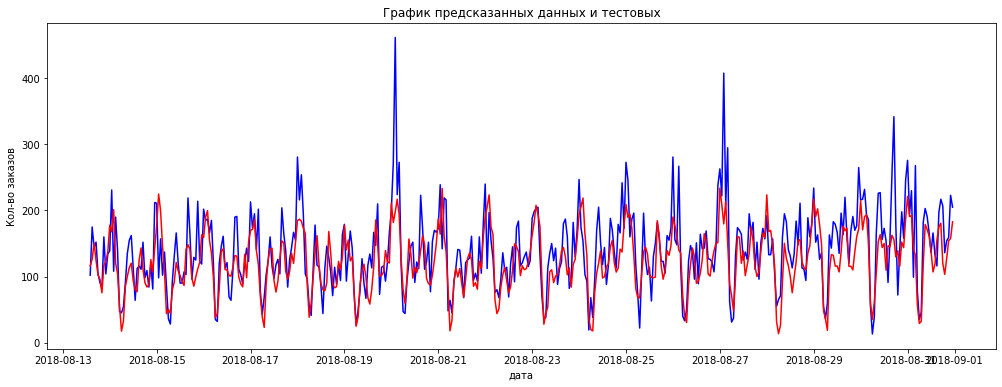

In [28]:
# Проверим модель на тестовой выборке.
model = LinearRegression()
model.fit(features_train, target_train)
pred_test=model.predict(features_test)
RMSE=mean_squared_error(target_test,pred_test)**0.5
print('Метрика RMSE на тестовой выборке',RMSE)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test,'b-',target_test.index,pred_test,'r-')
plt.title('График предсказанных данных и тестовых')
plt.xlabel('дата')
plt.ylabel('Кол-во заказов')

***Метрика тестовой выборки уловлетворяет условию задачи ***

## Выводы

*** В рамках данной задачи были изучен временной ряд с количеством заказов такси за 9 месяцев***

*** На этапе предобработки было произведено ресемплирование с периодом в 1 час. ***

*** На этапе анализа была произведена проверка на сезонность,тренд,остатки и стационарность ряда ***

*** На этапе обучения была написана функция добавляющая лаги и скользящее среднее. ***

*** Обучены 4 модели с перебором гипер параметров:Линейная регрессия ,случайного леса, Catboost,LgbLight ***

*** Чуть лучше значение RMSE на валидационной выборке показала линейная регрессия. RMSE по тестовой выборке оказался в пределах поставленной задачи.*** 